# Introduction

Now that we've gained some interesting insights from exploratory data analysis at the discography, album, and even at the track level, let's try another fundamentally different approach. 

Up to this point, we've taken the structure of Vince Staples' discography for granted and analyzed metrics within that structure - in other words, we've taken the albums that Vince has curated and handled them as units in our analysis - but let's now reject any of that structure and treat each track in the discography separately. If we cluster these songs based on the values of their audio features, what will the resulting clusters look like? Can we learn anything from these clusters? Will clusters closely resemble Vince's albums themselves? It's unlikely, but it's a question worth exploring; we might even end up with some interesting playlists as a consequence.

Throughout this cluster analysis we'll be utilizing the **K-Means** clustering algorithm to form our clusters, so that tracks with similar audio structure (as quantified by audio features) will be close to one another, with respect to Euclidean distance. We'll try to select an optimal number of clusters that will minimize intercluster and intracluster distances. 

Since we'll be grouping songs based on their audio features, and not based on any overarching theme or topic, an obvious expectation is that clusters will contain similarly sounding tracks, and thus I would anticipate that interludes and predominantly spoken-word tracks would fall into the same group, for example. However, since the clustering methodology will involve a variety of different audio metrics, we might be in for some surprises as to how similar some tracks will be on this basis vs our perceptions.

# Data Acquisition/Preprocessing

The first thing we'll do before applying any algorithms is load in our data and standardize it such that all audio features are on the same scale. This is necessary because, for one, our analysis will involve features that aren't on the [0,1] scale such as tempo. For two, standardizing features will allow us to adequately capture differences in any given feature, since as we saw in EDA, in many cases Vince's tracks do not operate on the full scale of the audio features due to the fact that Spotify calibrates these features using all forms of genres and media. For example, nearly all of Vince's tracks fall below 0.6 speechiness, since values of 1.0 are reserved for podcasts and talk-show related audio. Standardization allows us to rescale our features so that they coincide with the range that Vince's discography falls under.

While it's tempting to simply use all numerical variables at our fingertips to form clusters, this may overcomplicate cluster differentiation and lead to groupings that are difficult to analyze. So, we'll stick to the subset of features that we previewed in our exploratory analysis for simplicity. Note that track popularity is intentionally excluded from this list, given its strong bias toward recent releases (though it might be interesting to see how our subsequent clusters rank in popularity).

In [183]:
# Import standard libaries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Import data
tracks_df = pd.read_csv('tracks.csv', index_col = 'Unnamed: 0')
tracks_df.head()

album                album_id album_release_date  \
0  RAMONA PARK BROKE MY HEART  2G549zeda2XNICgLmU0pNW         2022-04-08   
1  RAMONA PARK BROKE MY HEART  2G549zeda2XNICgLmU0pNW         2022-04-08   
2  RAMONA PARK BROKE MY HEART  2G549zeda2XNICgLmU0pNW         2022-04-08   
3  RAMONA PARK BROKE MY HEART  2G549zeda2XNICgLmU0pNW         2022-04-08   
4  RAMONA PARK BROKE MY HEART  2G549zeda2XNICgLmU0pNW         2022-04-08   

                                     album_cover_url  \
0  https://i.scdn.co/image/ab67616d000048519fd6f5...   
1  https://i.scdn.co/image/ab67616d000048519fd6f5...   
2  https://i.scdn.co/image/ab67616d000048519fd6f5...   
3  https://i.scdn.co/image/ab67616d000048519fd6f5...   
4  https://i.scdn.co/image/ab67616d000048519fd6f5...   

                               album_cover_url_large                track_id  \
0  https://i.scdn.co/image/ab67616d00001e029fd6f5...  0lqAn1YfFVQ3SdoF7tRZO2   
1  https://i.scdn.co/image/ab67616d00001e029fd6f5...  7CvtBcThQ4piVKkfUXieig   
2  https://i.scdn.co/image/ab67616d00001e029fd6f5...  3MVFHHeksQCnVuKOjPN01M   
3  https://i.scdn.co/image/ab67616d00001e029fd6f5...  7jN5Abri3a1crehbnlWa1F   
4  https://i.scdn.co/image/ab67616d00001e029fd6f5...  77JeMQGOagAhWcMd99RYCO   

               track_name  track_number  disc_number  explicit_flag  ...  key  \
0               THE BEACH             1            1           True  ...    4   
1  AYE! (FREE THE HOMIES)             2            1           True  ...    3   
2                 DJ QUIK             3            1           True  ...    1   
3                   MAGIC             4            1           True  ...    4   
4                NAMELESS             5            1          False  ...   11   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -6.206     0       0.6310         0.888          0.000000    0.8230   
1    -7.063     1       0.0628         0.215          0.000000    0.0779   
2   -11.431     0       0.1380         0.422          0.000290    0.1920   
3    -6.684     0       0.1810         0.272          0.000097    0.4960   
4   -11.554     0       0.0958         0.887          0.434000    0.1400   

   valence    tempo  time_signature  
0    0.682  157.850               4  
1    0.287   95.022               4  
2    0.818   86.007               4  
3    0.284   89.970               4  
4    0.398   66.202               3  

[5 rows x 24 columns]

In [104]:
# Filter the dataframe down to just the columns that we'll want to utilize in our cluster formation

tracks_df_cluster_data = tracks_df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
tracks_df_cluster_data.head()

danceability  energy  loudness  speechiness  acousticness  \
0         0.593   0.947    -6.206       0.6310         0.888   
1         0.745   0.690    -7.063       0.0628         0.215   
2         0.829   0.593   -11.431       0.1380         0.422   
3         0.743   0.601    -6.684       0.1810         0.272   
4         0.553   0.341   -11.554       0.0958         0.887   

   instrumentalness  liveness  valence    tempo  
0          0.000000    0.8230    0.682  157.850  
1          0.000000    0.0779    0.287   95.022  
2          0.000290    0.1920    0.818   86.007  
3          0.000097    0.4960    0.284   89.970  
4          0.434000    0.1400    0.398   66.202

In [187]:
# Standardize the numerical columns using standard scaler

scaler = StandardScaler()

tracks_df_cluster_data = scaler.fit_transform(tracks_df_cluster_data)

# Choosing the number of clusters, K

Before we run our K-Means algorithm on the data, we'll need to know how many clusters we'll want to use a priori, as it's a key input parameter. For our purposes, a satisfactory value of K will produce clusters that sufficiently consolidate similarly structured tracks, as well as adequately differentiate tracks belonging to separate clusters. 

A value of K that's too small will lead to large clusters that fail to properly capture patterns amongst similar songs, and a value of K that's too large will over-capture these patterns (in the limit of K, each song will have its own cluster) and lead to many small clusters that aren't significantly discernible from one another. We'll want a value of K somewhere in the middle, where each cluster in theory captures a different aspect of Vince's discography. We'll need to be a bit conservative with our K though, since our dataset only comprises of 83 points.

To this end, let's confine our range of K to [1,10] and produce an elbow plot, which captures, for each value of K, the total squared distance between a given point and the centroid of the cluster it's assigned to, summed across all points in the dataset - we will refer to this as the "inertia" of a given K, and can be thought of as an aggregate measure of dissimilarity. The theoretically "optimal" value of K will be where the marginal reduction in inertia resulting from choosing a higher K begins to diminish significantly - in other words, where adding an extra cluster does little to further identify similarities in the dataset. This value of K is also known as the elbow.

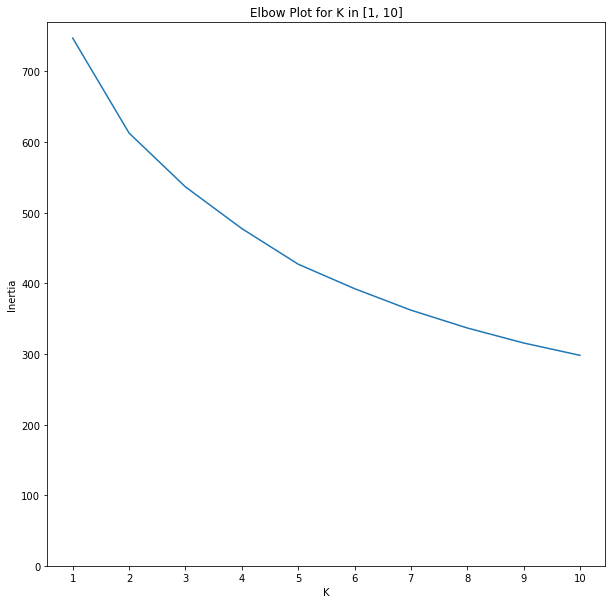

In [213]:
# Qualitatively determine the optimal value of K for cluster formation by producing an elbow plot
# Fit 10 KMeans models to the data, 1 for each K, and determine the inertia of each

K = range(1, 11)
ss = range(0, 800, 100)
inertia = []

for k in K:
    KMeans_model = KMeans(n_clusters = k, random_state = 123, n_init = 100)
    KMeans_model.fit(tracks_df_cluster_data)
    inertia.append(KMeans_model.inertia_)
    
# Plot inertia vs K

plt.figure(figsize = (10,10))

elbow_plot = sns.lineplot(x = K, y = inertia)
elbow_plot.set_xticks(list(K))
elbow_plot.set_yticks(list(ss))
elbow_plot.set_ylabel('Inertia')
elbow_plot.set_xlabel('K')
elbow_plot.set_title('Figure 1: Elbow Plot for K in [1, 10]')

plt.show()

Based on the above visual, there isn't a clear elbow to choose from in this range of K, due to the lack of a plateau. This makes our choice of K less of an obvious decision. Clearly, inertia will approach 0 as K approaches 83 (the total number of observations), and it's reasonable to expect that for some value of K larger than 10, the curve will eventually taper off as it converges on 0. Since we've self-imposed this small range of K to combat the issue of data sparsity, we don't have the luxury of finding that true elbow K-value. Therefore, we reason to select K as follows. 

While not as dramatic as we would otherwise observe (and prefer) with a larger dataset, we do see a clear demonstration of diminishing returns at play in this plot as we move left to right:

In [239]:
inertia_pct_delta = []
labels = []
for i in range(0, len(inertia) - 1):
    inertia_pct_delta.append("{:.2%}".format((inertia[i+1] - inertia[i])/inertia[i]))
    labels.append(str(i+1) + " to " + str(i+2))

K_delta = pd.DataFrame(dict(inertia_delta=inertia_pct_delta), index = labels)

K_delta

inertia_delta
1 to 2        -17.99%
2 to 3        -12.44%
3 to 4        -11.00%
4 to 5        -10.56%
5 to 6         -8.11%
6 to 7         -7.76%
7 to 8         -6.98%
8 to 9         -6.31%
9 to 10        -5.55%

As K increases, the proportional decrease in inertia also gets smaller in magnitude. While there are certainly plausible alternatives, I will opt to settle for K = 6, since this is the point at which inertia drops below 400, further increases in K will only result in single digit % decreases in inertia, and also because this number is close to the number of projects Vince has released (7 projects: 5 albums and 2 EPs), and thus may facilitate some comparison between clusters and his studio releases.

# Form clusters using KMeans, with K = 6

In [156]:
# Initialize KMeans model with 6 clusters and have them re-initialized 100 times
tracks_clusters_KMeans = KMeans(n_clusters = 6, random_state = 123, n_init = 100)

# Fit the model
tracks_clusters_KMeans.fit(tracks_df_cluster_data)

# Add cluster assignments as a column to tracks_df
cluster_assignments = pd.Series(tracks_clusters_KMeans.labels_, name = 'cluster_assignments')
tracks_w_clusters = pd.concat([tracks_df, cluster_assignments], axis = 1)

# Analyze clusters
cluster_group = tracks_w_clusters.groupby('cluster_assignments')

# Attach track counts to mean values table
mean_values_by_cluster = pd.concat([cluster_group.mean(), cluster_group.count().iloc[:,1]], axis = 1) 
mean_values_by_cluster

track_number  disc_number  explicit_flag  \
cluster_assignments                                             
0                        6.076923     1.076923       0.923077   
1                        6.312500     1.125000       0.937500   
2                        5.000000     1.000000       1.000000   
3                        5.846154     1.153846       0.846154   
4                        6.500000     1.166667       0.916667   
5                        7.000000     1.500000       1.000000   

                     track_popularity  track_duration_s  danceability  \
cluster_assignments                                                     
0                           46.538462        169.262846      0.720923   
1                           47.500000        145.997938      0.815750   
2                           44.400000        178.247800      0.679333   
3                           42.307692        107.149769      0.537385   
4                           44.000000        186.081750      0.760000   
5                           41.000000        248.706500      0.343000   

                       energy       key   loudness      mode  speechiness  \
cluster_assignments                                                         
0                    0.636385  4.076923  -8.073846  0.846154     0.181100   
1                    0.585500  5.500000  -8.331062  0.437500     0.162981   
2                    0.722600  4.933333  -6.397533  0.733333     0.228173   
3                    0.436700  7.230769 -13.510769  0.538462     0.409523   
4                    0.599042  5.666667  -7.835167  0.500000     0.156929   
5                    0.479500  9.500000  -9.571000  1.000000     0.049050   

                     acousticness  instrumentalness  liveness   valence  \
cluster_assignments                                                       
0                        0.164681          0.021241  0.134908  0.564538   
1                        0.494675          0.027754  0.137263  0.670875   
2                        0.245975          0.019414  0.546667  0.453933   
3                        0.550769          0.071903  0.367769  0.503892   
4                        0.102573          0.026292  0.174063  0.248804   
5                        0.075250          0.857500  0.195400  0.107300   

                          tempo  time_signature  album_id  
cluster_assignments                                        
0                    160.102308        3.923077        13  
1                     99.128187        3.875000        16  
2                    123.047467        4.000000        15  
3                     98.327231        4.153846        13  
4                    110.231417        4.000000        24  
5                    102.781000        4.000000         2

# What does each cluster represent?

The table above gives us some idea of the characteristics of each cluster, with the final column being a track count. First things first, we see that our choice of K seems to have been appropriate, as we see that the tracks seem to be distributed amongst the clusters fairly evenly, with the exceptions of clusters 4 and 5 (more on those in a bit). Clusters appear to have diverse album representation, as no cluster seems to be dominated by tracks from a single album. This supports our earlier notion that, within Vince's albums, thematic structure and audio structure are not necessarily one in the same (and moreover, that his albums have range).

Looking further at the mean values of various measures, all clusters seem to be similar in terms of average track popularity. Cluster 3 has noticeably shorter average track duration (which was not a feature used in the K-Means clustering process) than any other cluster, which in tandem with its relatively higher speechiness, seems to suggest that this may be the interlude cluster we anticipated at the onset of this analysis. 

Our overarching goal here is to understand the aspect/characteristic of Vince's discography that each cluster explains. So, let's use the intuitions gained from this table, alongside some handy boxplots generated using seaborn, to characterize and distinguish each cluster.

## Cluster 0 - High Tempo Tracks

Glancing at its average metrics, cluster 0 is middle of the pack for most measures - it's notably higher metrics are energy, danceability, and valence. More importantly, however, it is the clear winner when it comes to tempo (with tracks averaging 160 BPM), as the following plot demonstrates; this cluster is clearly a collection of the highest-paced songs.

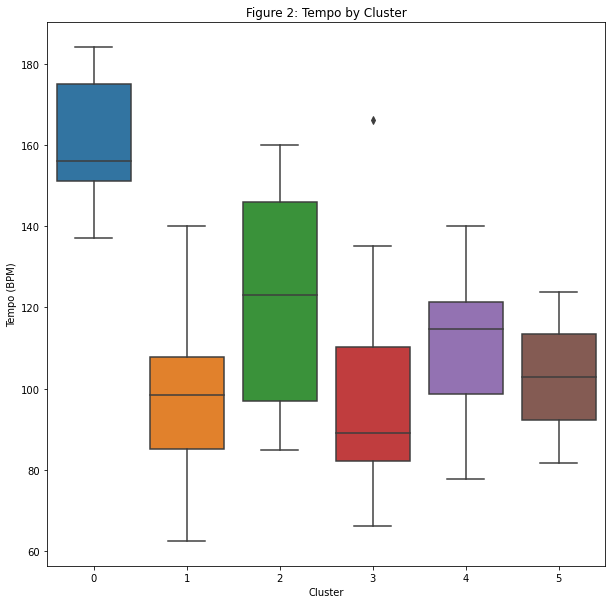

In [168]:
plt.figure(figsize = (10,10))

tempo_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'tempo')
tempo_plot.set_xlabel('Cluster')
tempo_plot.set_ylabel('Tempo (BPM)')
tempo_plot.set_title('Figure 2: Tempo by Cluster')

plt.show()

# Cluster 0 captures tracks with highest tempo

In [165]:
# Get the list of tracks within cluster 0

tracks_w_clusters[tracks_w_clusters['cluster_assignments'] == 0][['album', 'album_release_date', 'track_name', 'explicit_flag']].head(n = 30)

album album_release_date         track_name  \
5   RAMONA PARK BROKE MY HEART         2022-04-08    WHEN SPARKS FLY   
8   RAMONA PARK BROKE MY HEART         2022-04-08          PAPERCUTS   
20               Vince Staples         2021-07-09       TAKING TRIPS   
23               Vince Staples         2021-07-09           LIL FADE   
25               Vince Staples         2021-07-09                MHM   
28                         FM!         2018-11-02  Don't Get Chipped   
39             Big Fish Theory         2017-06-23   Alyssa Interlude   
44             Big Fish Theory         2017-06-23             Homage   
54                 Prima Donna         2016-08-25          Pimp Hand   
61              Summertime '06         2015-06-30         Lemme Know   
62              Summertime '06         2015-06-30            Dopeman   
67              Summertime '06         2015-06-30               3230   
81               Hell Can Wait         2014-09-23              Limos   

    explicit_flag  
5            True  
8            True  
20           True  
23           True  
25           True  
28           True  
39          False  
44           True  
54           True  
61           True  
62           True  
67           True  
81           True

## Cluster 1 - Happy & Acoustic Dance Tracks

While many of the songs in Vince's discography tend to have high danceability scores, cluster 1 and cluster 4 contain the most danceable track collections of the bunch (see Figure 3), and therefore these two clusters appear to partition Vince's highly danceable music. So then how do the two differentiate from one another?

As evident by the subsequent boxplot in Figure 4, one aspect in which these two clusters differ mightily is valence. The tracks in cluster 1 are amongst the highest in valence in Vince's entire discography (furthermore, cluster 1 has the highest average valence), while cluster 4 contains the songs lowest in valence, aside from the two tracks in cluster 5. We can deduce that cluster 1's tracks are happier-sounding, while cluster 4 has the darker tracks.

Additionally, Figure 5 makes evident that cluster 1 contains the most acoustic tracks of any *musical* cluster, while cluster 4 conversely appears to have tracks that tend toward low to no acousticness (with 3 outlier songs). Given all of our findings, a fair assessment of cluster 1 is that it contains the subset of Vince's dance tracks that are more euphonious and acoustic, and less like techno-like.

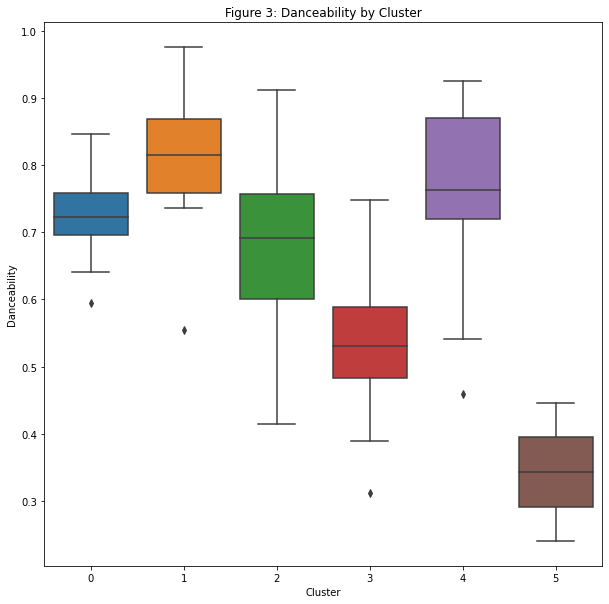

In [177]:
plt.figure(figsize = (10,10))

dance_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'danceability')
dance_plot.set_xlabel('Cluster')
dance_plot.set_ylabel('Danceability')
dance_plot.set_title('Figure 3: Danceability by Cluster')

plt.show()
# Clusters 1 and 4 contain a greater proportion of his 'dancier' songs

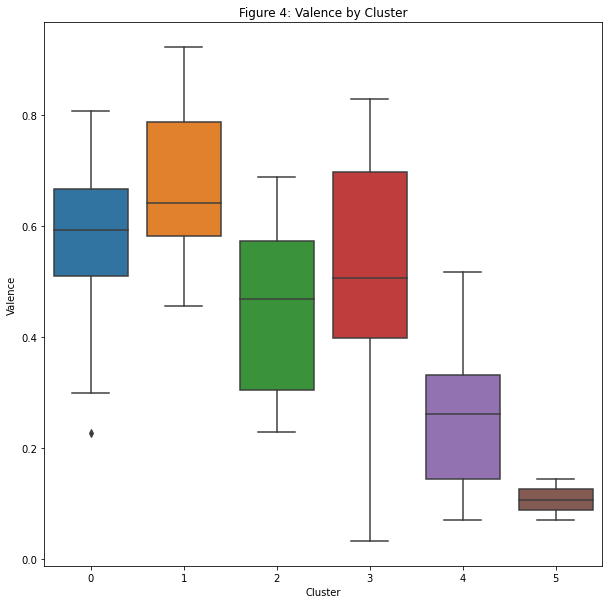

In [169]:
plt.figure(figsize = (10,10))

valence_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'valence')
valence_plot.set_xlabel('Cluster')
valence_plot.set_ylabel('Valence')
valence_plot.set_title('Figure 4: Valence by Cluster')

plt.show()
# Cluster 5 also captures the two least 'happy' sounding tracks in Vince's discography

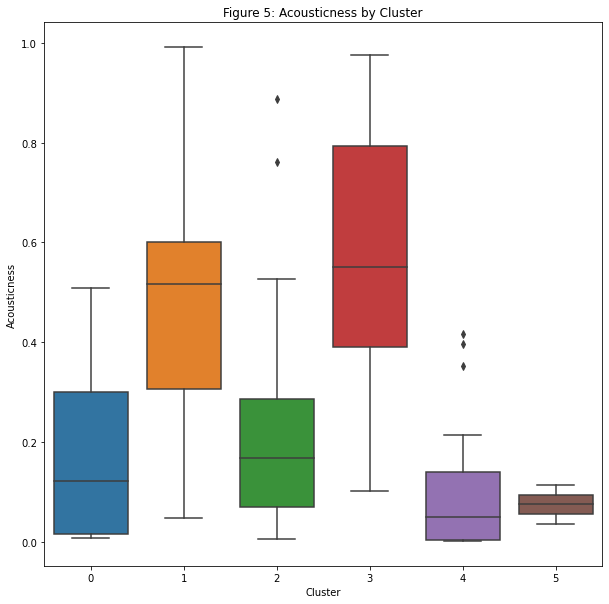

In [171]:
plt.figure(figsize = (10,10))

acoustic_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'acousticness')
acoustic_plot.set_xlabel('Cluster')
acoustic_plot.set_ylabel('Acousticness')
acoustic_plot.set_title('Figure 5: Acousticness by Cluster')

plt.show()

# Cluster 3 contains a wide range of acousticness, due to the fact that some interludes feature acoustic instrumentals, while others may have little background instrumentals at all
# Cluster 1 contains the most acoustic musical tracks. Conversely, the dance tracks in cluster 4 are very low in acousticness

In [173]:
# Get the list of tracks within cluster 1

tracks_w_clusters[tracks_w_clusters['cluster_assignments'] == 1][['album', 'album_release_date', 'track_name', 'explicit_flag']].head(n = 30)

album album_release_date  \
2   RAMONA PARK BROKE MY HEART         2022-04-08   
9   RAMONA PARK BROKE MY HEART         2022-04-08   
11  RAMONA PARK BROKE MY HEART         2022-04-08   
12  RAMONA PARK BROKE MY HEART         2022-04-08   
13  RAMONA PARK BROKE MY HEART         2022-04-08   
16               Vince Staples         2021-07-09   
18               Vince Staples         2021-07-09   
27                         FM!         2018-11-02   
30                         FM!         2018-11-02   
32                         FM!         2018-11-02   
38             Big Fish Theory         2017-06-23   
47             Big Fish Theory         2017-06-23   
50                 Prima Donna         2016-08-25   
68              Summertime '06         2015-06-30   
71              Summertime '06         2015-06-30   
82               Hell Can Wait         2014-09-23   

                        track_name  explicit_flag  
2                          DJ QUIK           True  
9                         LEMONADE           True  
11                      MAMA'S BOY           True  
12                       BANG THAT           True  
13      THE SPIRIT OF MONSTER KODY           True  
16              ARE YOU WITH THAT?           True  
18                    SUNDOWN TOWN           True  
27                        Outside!           True  
30  New earlsweatshirt - Interlude           True  
32                            FUN!           True  
38                        Big Fish          False  
47                          BagBak           True  
50                       War Ready           True  
68                            Surf           True  
71                    Street Punks           True  
82                Feelin' The Love           True

## Cluster 2 - Energetic & Performative Tracks

Cluster 2 is interesting. Its collection of tracks tend to be higher energy, as Figure 6 depicts. It contains a very broad range of tempos, per Figure 2, and most importantly, it's the clear leader of the pack when it comes to liveness as Figure 7 shows (with the exception of some outlier tracks from cluster 3).

So, cluster 2 contains the most energetic and perceivably live songs - perhaps this suggests that the cluster defines Vince's most performative tracks. Having glanced at the list of tracks, it's likely that the animated nature of these tracks, combined with the unorthodox instrumentals containing elements that are likely perceived to resemble an audience (such as echoes, ambient beach noises, or vocal samples) by Spotify's audio analysis tool, are what set these tracks apart from the rest of the catalogue.

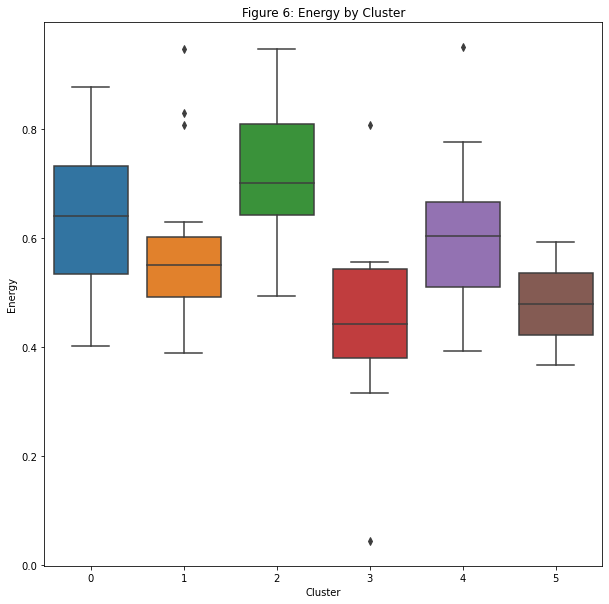

In [174]:
plt.figure(figsize = (10,10))

energy_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'energy')
energy_plot.set_xlabel('Cluster')
energy_plot.set_ylabel('Energy')
energy_plot.set_title('Figure 6: Energy by Cluster')

plt.show()

# Cluster 2 tends toward the more energetic tracks

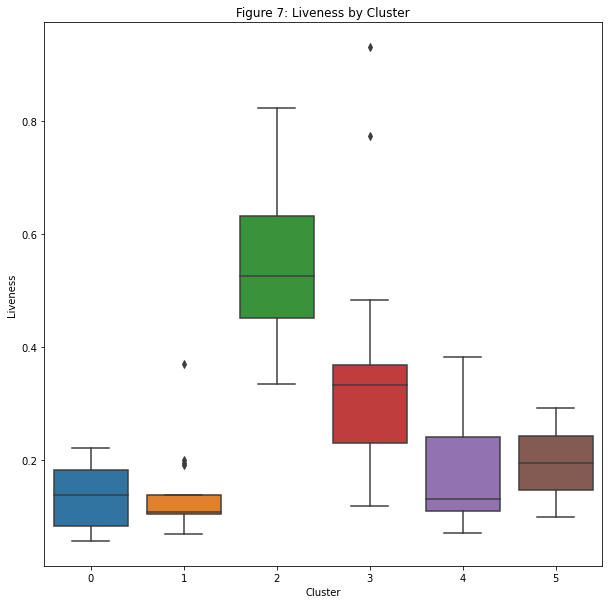

In [176]:
plt.figure(figsize = (10,10))

liveness_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'liveness')
liveness_plot.set_xlabel('Cluster')
liveness_plot.set_ylabel('Liveness')
liveness_plot.set_title('Figure 7: Liveness by Cluster')

plt.show()

# Cluster 2 is far and away the most perceivably "live" collection of the group.
# Cluster 3 tails it, which intuitively makes sense, since an interlude is more likely to sound conversational, which may be interpreted as live

In [178]:
# Get the list of tracks within cluster 2

tracks_w_clusters[tracks_w_clusters['cluster_assignments'] == 2][['album', 'album_release_date', 'track_name', 'explicit_flag']].head(n = 30)

album album_release_date         track_name  \
0   RAMONA PARK BROKE MY HEART         2022-04-08          THE BEACH   
3   RAMONA PARK BROKE MY HEART         2022-04-08              MAGIC   
15  RAMONA PARK BROKE MY HEART         2022-04-08          THE BLUES   
26                         FM!         2018-11-02  Feels Like Summer   
29                         FM!         2018-11-02              Relay   
31                         FM!         2018-11-02      Run the Bands   
33                         FM!         2018-11-02         No Bleedin   
40             Big Fish Theory         2017-06-23     Love Can Be...   
51                 Prima Donna         2016-08-25              Smile   
53                 Prima Donna         2016-08-25        Prima Donna   
59              Summertime '06         2015-06-30       Birds & Bees   
63              Summertime '06         2015-06-30  Jump Off The Roof   
77               Hell Can Wait         2014-09-23          65 Hunnid   
79               Hell Can Wait         2014-09-23           Hands Up   
80               Hell Can Wait         2014-09-23         Blue Suede   

    explicit_flag  
0            True  
3            True  
15           True  
26           True  
29           True  
31           True  
33           True  
40           True  
51           True  
53           True  
59           True  
63           True  
77           True  
79           True  
80           True

## Cluster 3 - Interludes & Skits

Cluster 3, as we briefly touched on in the beginning of this section, is the easiest to distinguish; this is the interlude-exclusive cluster.

It stands out from the rest in that it is the only cluster with non-negligible speechiness values, as shown in Figure 8. Vince's interludes commonly present a simple instrumental over which an individual or group of individuals speak regarding an experience or topic. Given that the focus of these tracks is on the speech, and not so much on the background audio, their speechiness values are substantial.

Additionally, while the difference is not quite as pronounced as cluster 2, cluster 3 does stand out from the majority of other clusters when it comes to liveness - see Figure 8. The conversational style of interlude tracks is likely what contributes to this, as the speaker in the track obviously is not trying to adhere to a certain melodious structure, which in turn is likely convincing the audio tool that an audience is present in interlude tracks that feature background music. Furthermore, energy values are low (Figure 6), signifying that the speaker is not trying to be performative, nor does the production try to steal the show.

It is worth mentioning that this cluster does still contain a few musical tracks, and also does not encompass every single interlude. Having looked through the track list, my qualitative interpretation is that these musical tracks feature some of Vince's more casual, colloquial delivery, which may be recognized by the interpreter as monologues over strong instrumentals, hence why these tracks tend to be lower energy and higher speechiness.

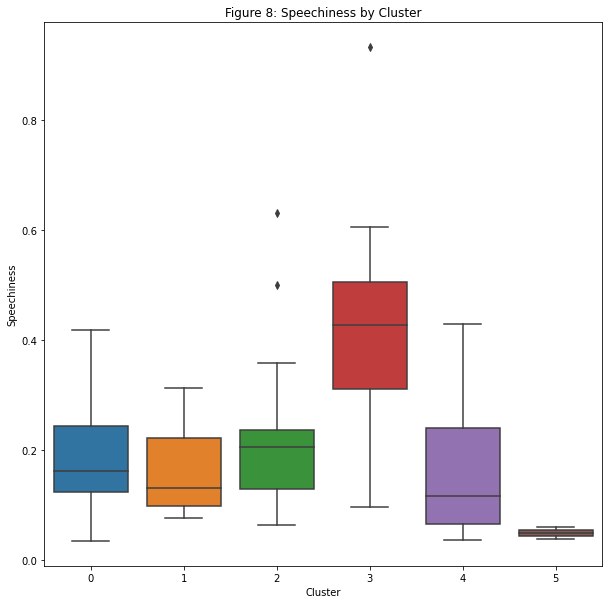

In [179]:
plt.figure(figsize = (10,10))

speech_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'speechiness')
speech_plot.set_xlabel('Cluster')
speech_plot.set_ylabel('Speechiness')
speech_plot.set_title('Figure 8: Speechiness by Cluster')

plt.show()

# Cluster 3 contains most of the interlude-type tracks, which exhibit relatively higher speechiness and less overall musical content

In [181]:
# Get the list of tracks within cluster 3

tracks_w_clusters[tracks_w_clusters['cluster_assignments'] == 3][['album', 'album_release_date', 'track_name', 'explicit_flag']].head(n = 30)

album album_release_date  \
4   RAMONA PARK BROKE MY HEART         2022-04-08   
7   RAMONA PARK BROKE MY HEART         2022-04-08   
10  RAMONA PARK BROKE MY HEART         2022-04-08   
17               Vince Staples         2021-07-09   
21               Vince Staples         2021-07-09   
22               Vince Staples         2021-07-09   
24               Vince Staples         2021-07-09   
35                         FM!         2018-11-02   
42             Big Fish Theory         2017-06-23   
49                 Prima Donna         2016-08-25   
56              Summertime '06         2015-06-30   
66              Summertime '06         2015-06-30   
74              Summertime '06         2015-06-30   

                       track_name  explicit_flag  
4                        NAMELESS          False  
7                           SLIDE           True  
10                    PLAYER WAYS           True  
17                LAW OF AVERAGES           True  
21           THE APPLE & THE TREE           True  
22                   TAKE ME HOME           True  
24                  LAKEWOOD MALL           True  
35          (562) 453-9382 - Skit           True  
42  Ramona Park Is Yankee Stadium          False  
49                   Let It Shine           True  
56       Ramona Park Legend Pt. 1           True  
66       Ramona Park Legend Pt. 2           True  
74                     Like It Is           True

## Cluster 4 - Dark & Electronic Dance Tracks (Vince's Niche)

Recall from our discussion of cluster 1 that Vince's most danceable tracks have been partitioned between clusters 1 and 4. We found cluster 1 to contain the jubilant and acoustic such dance songs, so now we'll see how cluster 4 contrasts.

One noteworthy detail to kick off with is regarding cluster size - cluster 4 contains the most songs of any cluster, and by a decent margin. It contains 24 tracks while the other clusters (aside from the anomalous cluster 5) contain anywhere between 13-16. One obvious deduction from this is that this is the most common niche of Vince's music, and thus is perhaps most characteristic of Vince's music style. Moreover, since cluster 1 and cluster 4 serve to differentiate all of his highly danceable tracks, it's clear when you consider their combined track count that Vince's discography is nearly 50% danceable music. 

As Figure 5 proved to us, cluster 4 holds the dance tracks that are least acoustic, and thus most electronic sounding. To exemplify this fact, the tracklist contains half of the entire ***Big Fish Theory*** album, a heavily techno-influenced album, and contains 8 of the most electronic tracks from Vince's ***Summertime '06***. These tracks are all dim in tone and production, as reflected by their relatively low valence scores in Figure 4. Additionally, per Figure 1, the range of tempos exhibited in these tracks is higher and thus closer to house/techno than the dance tracks in cluster 1.

These findings suggest that a satisfactory description for this cluster would be dark, electronic-inspired dance music, which evidently has been a prevailing style in Vince's work.

In [184]:
# Get the list of tracks within cluster 4

tracks_w_clusters[tracks_w_clusters['cluster_assignments'] == 4][['album', 'album_release_date', 'track_name', 'explicit_flag']].head(n = 30)

album album_release_date                  track_name  \
1   RAMONA PARK BROKE MY HEART         2022-04-08      AYE! (FREE THE HOMIES)   
6   RAMONA PARK BROKE MY HEART         2022-04-08           EAST POINT PRAYER   
14  RAMONA PARK BROKE MY HEART         2022-04-08                 ROSE STREET   
19               Vince Staples         2021-07-09                 THE SHINING   
34                         FM!         2018-11-02  Brand New Tyga - Interlude   
36                         FM!         2018-11-02                    Tweakin'   
37             Big Fish Theory         2017-06-23           Crabs In A Bucket   
41             Big Fish Theory         2017-06-23                         745   
43             Big Fish Theory         2017-06-23                  Yeah Right   
45             Big Fish Theory         2017-06-23                        SAMO   
46             Big Fish Theory         2017-06-23                Party People   
48             Big Fish Theory         2017-06-23              Rain Come Down   
52                 Prima Donna         2016-08-25                        Loco   
55                 Prima Donna         2016-08-25                    Big Time   
57              Summertime '06         2015-06-30                  Lift Me Up   
58              Summertime '06         2015-06-30                   Norf Norf   
60              Summertime '06         2015-06-30                        Loca   
64              Summertime '06         2015-06-30                    Señorita   
70              Summertime '06         2015-06-30                    Get Paid   
72              Summertime '06         2015-06-30                Hang N' Bang   
73              Summertime '06         2015-06-30                      C.N.B.   
75              Summertime '06         2015-06-30                         '06   
76               Hell Can Wait         2014-09-23                        Fire   
78               Hell Can Wait         2014-09-23                 Screen Door   

    explicit_flag  
1            True  
6            True  
14           True  
19           True  
34           True  
36           True  
37           True  
41          False  
43           True  
45           True  
46           True  
48          False  
52           True  
55           True  
57           True  
58           True  
60           True  
64           True  
70           True  
72           True  
73           True  
75           True  
76           True  
78           True

## Cluster 5 - Dreary Instrumental-Dominant Tracks (Instrumentalness Outliers)

Cluster 5, which consists of only 2 tracks, is a very unique one. The two tracks within it score relatively low on most metrics, with the clear exception being instrumentalness. 

Note first, via Figure 3, that these 2 tracks are very low in danceability, which is rare for Vince as previously mentioned. They are also very low in valence and acousticness via Figure 4 and Figure 5, which represent that these are depressive and electronically amplified tracks.

Most notable, however, is that these two tracks score virtually zero in speechiness (see Figure 8), and are near the max score of 1 in instrumentalness, while all other clusters are practically zero (see Figure 9). These two key points clue us in that these two tracks are primarily instrumental tracks with no dominant vocals. 

Indeed, the two tracks are "Might Be Wrong" and "Summertime" from the ***Summertime '06*** and feature strong melancholy instrumentals, with no actual rapping from Vince. "Might Be Wrong" centralizes around the ominous beat while some very faint audio plays of a phone call between Vince and his incarcerated friend, in which they harp on rising murder rates and injustices in Long Beach. These audio excerpts are separated by a short and harrowing hook. "Summertime" features yet another dominant and layered instrumental, over which an electronically tuned version of Vince's voice speaks to his girlfriend in a sorrowful and hollowed manner regarding their failing relationship.

While clearly the two constitutent tracks aren't entirely devoid of speech, the vocals take a backseat to the harmonious production, which explains their high instrumentalness. I believe here that Vince intentionally has the music drown out the vocals in an attempt at juxtaposition; the cruel, harsh realities behind his words are muffled by the conventionally warm and blissful season, represented by the instrumentals.

While instrumental-dominant tracks are a rarity in Vince's discography, making it a sensible result that they comprise of their own cluster, I don't believe these are the only two tracks that exhibit such properties. Both of the interludes from the ***Vince Staples*** album share similar properties in which the vocals take on a secondary role to the prominent instrumental, however the defining difference that's likely at play here is that the sounds featured in those songs represent acoustic instruments, unlike the electronically amplified tracks in cluster 5 which score very low in acousticness.

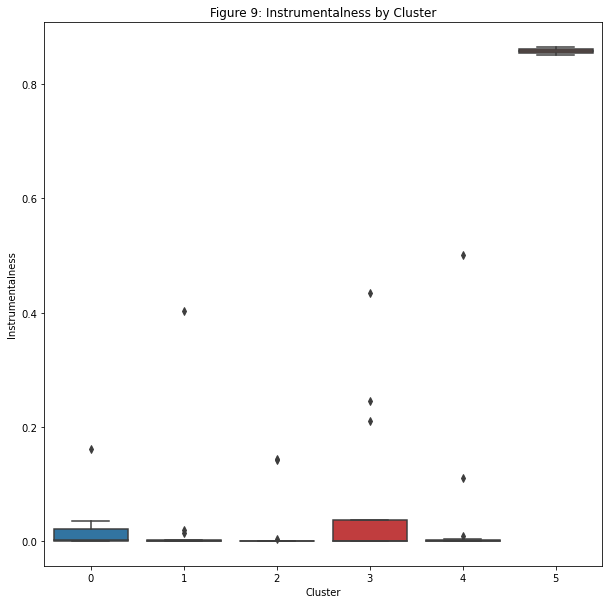

In [186]:
plt.figure(figsize = (10,10))

instrumental_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'instrumentalness')
instrumental_plot.set_xlabel('Cluster')
instrumental_plot.set_ylabel('Instrumentalness')
instrumental_plot.set_title('Figure 9: Instrumentalness by Cluster')


plt.show()

# Cluster 5 appears to be reserved for the tracks (only 2 of them) which appear to be outliers with regard to instrumentalness

In [185]:
# Get the list of tracks within cluster 5

tracks_w_clusters[tracks_w_clusters['cluster_assignments'] == 5][['album', 'album_release_date', 'track_name', 'explicit_flag']].head(n = 30)

album album_release_date      track_name  explicit_flag
65  Summertime '06         2015-06-30      Summertime           True
69  Summertime '06         2015-06-30  Might Be Wrong           True

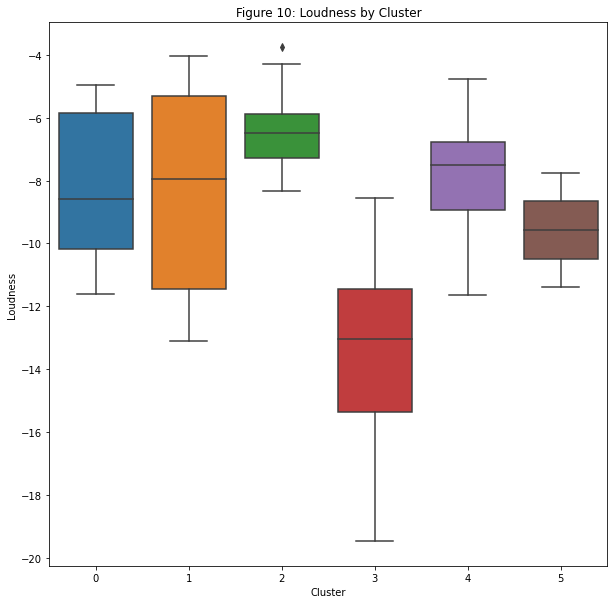

In [240]:
plt.figure(figsize = (10,10))

loudness_plot = sns.boxplot(data = tracks_w_clusters, x = 'cluster_assignments', y = 'loudness')
loudness_plot.set_xlabel('Cluster')
loudness_plot.set_ylabel('Loudness')
loudness_plot.set_title('Figure 10: Loudness by Cluster')

plt.show()



# Conclusion & Discussion

In this section, we performed K-Means clustering on the tracks - using their audio features studied in the previous notebook - to create a novel partition of Vince's musical discography. In essence, we created 6 of our own albums and EPs on the basis of audio similarity. The results were mixed, but pretty interesting - to name a few, we had a cluster primarily devoted to interludes and spoken-word tracks in cluster 3, we had two clusters divide up Vince's danceable tracks in 1 and 4, and we even had a very small outlier cluster 5 which housed 2 instrumentally-dominant tracks. We deemed cluster 4, which was the most populated cluster, to be the most representative of Vince's style which is dark, non-acoustic, danceable music. The boxplots we generated for each feature helped demonstrate the focal points of each cluster, and also gave us a sense of variability within each cluster.

If I were tasked with creating a Vince Staples playlist for someone who has never listened to his music before, and was only given these 6 clusters as options, I would most likely settle for cluster 4. Simply put, it contains a pretty representative range of Vince's most known and accessible tracks; I notice a lot of his popular singles can be found within it. It does suffer a bit when it comes to diversity in that most tracks hail from 2 albums, but I would guess that this playlist would have a relatively higher likelihood of creating a new Vince Staples fan than any of the others, though that may also have to do with the fact that it has more songs (and thus more opportunities to allure listeners). I definitely think that if I were given free-reign to create my own playlist, though, that it would look quite different.

That being said, these results are obviously not perfect in the sense that clusters are vastly different from one another. In certain cases, some tracks feel slightly out of place within their assigned cluster - a glaring example is the existence of musical tracks found in cluster 3. We can chalk this up to the imperfect circumstances and limitations surrounding this project. For one, we had to take some creative liberties when it came to K, the sheer number of cluster to create. Perhaps our results would be more insightful and clusters would've been more uniform had we decided to impose less of a restriction on K, and opt for more clusters altogether. 

Working with a relatively small dataset of 83 observations clearly came with sacrifices, so it would be worth reperforming this exercise with an older artist who's had a long musical career (and thus an extensive discography). In such a circumstance, we would more likely be able to make an objective choice of K and find greater utility in our clusters. Our analysis could also perhaps benefit from incorporation of other track variables we intentionally left out from this exercise - there could be key track aspects that we aren't considering in our cluster formation, which might lead to more defined results. What if we *did* include track length and popularity? Maybe some of the missing key characteristics aren't being captured by Spotify's tool altogether.

In terms of an alternative analytical approach to K-Means, Principal Component Analysis was another idea I floated prior to embarking on this assignment. My idea was to take the standardized audio feature matrix and assemble an appropriate number of PCs to explain the majority of variance within the dataset. Then, we could analyze the loadings of each PC to determine what aspects of the tracks they represent. If our total number of PCs was low enough (3 or fewer), we could furthermore plot the z-scores of each track along with the PC loadings to get a visual representation/ranking of each track. Doing so might reveal some interesting facts about the discography, as well as outlier tracks. Going even further and using our PCs as output (assuming they were satisfactory), we could try our hand at more bivariate exploratory analysis between these features and track popularity, and try to assemble a low-dimensional regression model. That's me just spit-balling ideas at this point, though.

Overall, this has been a very insightful activity, and I look forward to carrying this experience forward into my next project in clustering, data exploration, and modeling. If you've made it this far, thank you for reading.